In [1]:
import os
import re
import glob
import importlib
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.windows import from_bounds
from rasterio.features import rasterize
from rasterio.transform import from_origin
from rasterio.transform import Affine
import datetime as dt
from osgeo import gdal, osr
from osgeo.gdalconst import *
import shade_setup as shade
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
from shapely.geometry import mapping

import matplotlib.pyplot as plt



from scipy.ndimage import median_filter
from scipy.ndimage import uniform_filter
from scipy.ndimage import gaussian_filter
from scipy.ndimage import minimum_filter

import startinpy

importlib.reload(shade)

pd.set_option('display.max_columns', None) #-- to show all columns in a dataframe. To reset: pd.reset_option(“max_columns”)


### What I want to do:

- stepwise load dsm in a folder
- find corresponding CHM (polygon or tif)
    - load ahn subtiles
    - use dsm bounds to identify tiles
    - load tiles, union/merge; or can I mask without?
- mask canopy from dsm, 
- mask buildings from dsm
- interpolate

- save with the buffer removed (I created points at 300m intervals for AMS West, queried 350m, so have 25m on all sides to remove, should probably remove less so that I still have an overlap for shade calculation)
    - save results? Yes, makes it easier to replicate.

- load buildings_only_dsm and canopy_dsm
    - run shade calculation for longest day of the year
        - buildings only
        - buildings and trees

- combine neighbourhood raster?
- load verhardingen
- statistics

## Functions:

In [2]:
def reproject_raster_to_dsm(src_raster, src_transform, src_crs, dst_crs, dst_transform, dst_shape):
    """
    Reproject a raster to the DSM's CRS.
    
    The CHM might be in a different CRS to the DSM.

    This function reprojects the CHM to the DSM crs.
    """
    dst_raster = np.empty(dst_shape, dtype=src_raster.dtype)
    reproject(
        source=src_raster,
        destination=dst_raster,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )
    return dst_raster

def update_mask_within_extent(raster_path, combined_mask, dsm_bounds, dsm_transform, dsm_crs, dsm_shape):
    """
    This function reflects the fact that each DSM tile only overlaps the CHM partially, or overlaps multiple CHM tiles.
    
    We already have a list of CHM tiles that overlap. 
    
    In this function we open the tile(s), reproject, and compute the window in which the CHM overlaps with the DSM
     
    Then we use the data in the window to create a raster mask for the original DSM"""
    with rasterio.open(raster_path) as src:
        # Reproject the entire additional raster to the DSM's CRS
        src_data = src.read(1)
        src_transform = src.transform
        src_crs = src.crs
        
        reprojected_data = reproject_raster_to_dsm(
            src_data, src_transform, src_crs, dsm_crs, dsm_transform, dsm_shape
        )
        
        # Compute the window of the reprojected raster that overlaps with the DSM extent
        window = from_bounds(
            left=dsm_bounds.left, bottom=dsm_bounds.bottom,
            right=dsm_bounds.right, top=dsm_bounds.top,
            transform=dsm_transform
        )

        # Convert window indices to integers
        row_off = int(window.row_off)
        col_off = int(window.col_off)
        height = int(window.height)
        width = int(window.width)

        # Extract the overlapping window from the reprojected raster
        window_data = reprojected_data[
            row_off:row_off + height,
            col_off:col_off + width
        ]

        # Create a mask from the reprojected raster within the window
        additional_mask = window_data > 0  # Example condition to create a mask from the additional raster
        
        # Update the combined mask using the window's index
        row_start, col_start = row_off, col_off
        row_end, col_end = row_start + additional_mask.shape[0], col_start + additional_mask.shape[1]

        # Ensure the indices are within the bounds of the combined mask
        if row_start < 0 or col_start < 0 or row_end > combined_mask.shape[0] or col_end > combined_mask.shape[1]:
            print(f"Skipping {raster_path} due to out of bounds indices")
            return

        combined_mask[row_start:row_end, col_start:col_end] |= additional_mask


### FILTER FUNCTIONS:


# Function to apply a median filter to a raster dataset
def apply_median_filter(data, nodata_value, size=3, nodata=True):
    
    if nodata:
        # Create a mask for nodata values
        mask = (data == nodata_value)
    
        # Apply the median filter only to valid data
        filtered_data = data.copy()
        filtered_data[~mask] = median_filter(data[~mask], size=size)
        print('Filtering: Ignoring Nodata')
    else:
        filtered_data = data.copy()
        filtered_data = median_filter(data, size=size)
        print('Filtering; Handling nodata')
    
    return filtered_data


# Function to apply a mean filter to a raster dataset
def apply_mean_filter(data, nodata_value, size=3):
    # Create a mask for nodata values
    mask = (data == nodata_value)
    
    # Apply the mean filter only to valid data
    filtered_data = data.copy()
    filtered_data[~mask] = uniform_filter(data[~mask], size=size)
    
    return filtered_data

# Function to apply a Gaussian filter to a raster dataset
def apply_gaussian_filter(data, nodata_value, sigma=1):
    # Create a mask for nodata values
    mask = (data == nodata_value)
    
    # Apply the Gaussian filter only to valid data
    filtered_data = data.copy()
    filtered_data[~mask] = gaussian_filter(data[~mask], sigma=sigma)
    
    return filtered_data

# # Function to apply a minimum filter to a raster dataset
# def apply_minimum_filter(data, nodata_value, size=3):
#     # Create a mask for nodata values
#     mask = (data == nodata_value)
    
#     # Apply the Gaussian filter only to valid data
#     filtered_data = data.copy()
#     filtered_data[~mask] = minimum_filter(data[~mask], size=size)
    
#     return filtered_data

# Function to apply a minimum filter to a raster dataset
def apply_minimum_filter(data, nodata_value, size=3, nodata=True):
    
    if nodata: 
        # Create a mask for nodata values
        mask = (data == nodata_value)
        
        # Apply the Gaussian filter only to valid data
        filtered_data = data.copy()
        filtered_data[~mask] = minimum_filter(data[~mask], size=size)
        print('Filtering: Ignoring Nodata')
    else:
        filtered_data = data.copy()
        filtered_data = minimum_filter(data, size=size)
        print('Filtering; Handling nodata')

    
    return filtered_data


### CROP AND SAVE RASTER

def crop_and_save_raster(raster, transform, meta, nodata, n, out_path):
    
    # Calculate new top-left corner coordinates
    new_x = transform.c + n * transform.a
    new_y = transform.f + n * transform.e

    # Calculate new transformation matrix
    new_transform = Affine(transform.a, transform.b, new_x,
                        transform.d, transform.e, new_y)

    # Crop the data by removing n pixels from each edge
    cropped_data = raster[n:-n, n:-n]

    # Update the metadata
    meta.update({
        'height': cropped_data.shape[0],
        'width': cropped_data.shape[1],
        'transform': new_transform
    })

    # Save the cropped raster data
    with rasterio.open(out_path, 'w', **meta) as dst:
        dst.write(cropped_data, 1)
        if nodata is not None:
            dst.nodata = nodata

    print(f"Cropped raster saved to {out_path}")

def check_files_exist(file_paths):
    """
    Check if all files in the list exist.

    Parameters:
    file_paths (list of str): List of file paths to check.

    Returns:
    bool: True if all files exist, False otherwise.
    """
    return all(os.path.exists(file_path) for file_path in file_paths)



### The 
# Function to extract the identifier from the file path
def extract_identifier(path):
    # Extract the last segment of the path
    last_segment = path.split('/')[-1]
    
    # Use regular expression to match the pattern before _20xx_
    match = re.match(r'(.*)_20\d{2}_', last_segment)
    
    if match:
        identifier = match.group(1)
    else:
        identifier = last_segment.split('_20')[0]
    
    return identifier

def directory_check(directory, shadow_check=True):
    """
    Check if the directory exists and contains 'shadow_fraction_on_' files.

    Parameters:
    directory (str): The path to the directory to check/create.
    shadow_check (bool): Whether to check for shadow_fraction_on_ files.

    Returns:
    bool: True if the directory exists and contains the required files, False otherwise.
    """
    # Check if the directory exists
    if not os.path.exists(directory):
        # Create the directory
        os.makedirs(directory)
        print(f"Directory {directory} created.")
    
    print(f"Directory {directory} already exists.")
    
    if shadow_check:
        # Check for files containing 'shadow_fraction_on_' in their names
        shadow_files = [f for f in os.listdir(directory) if 'shadow_fraction_on_' in f]
        
        if shadow_files:
            print(f"Files containing 'shadow_fraction_on_' found: {shadow_files}")
            return True  # Required files found
        else:
            print("No files containing 'shadow_fraction_on_' found.")
            return False  # Required files not found

    

In [3]:
## Solar API downloads are organised per OSM ID for which they are downloaded. Change to select a different area:
# Common ID's:
# - Amsterdam West: 15419236

osmid = 15419236

In [4]:
# Directory containing the raster files
raster_dir = f'../data/clean_data/solar/{osmid}'

# Get a list of all raster files in the directory so we can load them incrementally
raster_files = glob.glob(os.path.join(raster_dir, '*dsm.tif'))

print(len(raster_files))


236


## Pre-processing DSM

- mask out canopy
    - create chm
    - create building only dsm

In [7]:
# Process each DSM file
for path in raster_files:
    # Find the index of the last '/' character
    last_slash_index = path.rfind('/')
    # Extract the part after the last '/' (excluding '/')
    file_name = path[last_slash_index + 1:]
    file_name_building = f'../data/clean_data/solar/{osmid}/rdy_for_processing/' + file_name[:-7] + "building_dsm.tif"
    file_name_trees = f'../data/clean_data/solar/{osmid}/rdy_for_processing/' + file_name[:-7] + "canopy_dsm.tif"

    # List of file paths to check
    file_paths = [file_name_building, file_name_trees]

    # Check if the files already exist
    if check_files_exist(file_paths):
        print("Files already exist. Skipping creation.")
    else:
        # Read DSM
        with rasterio.open(path) as src:
            dsm_data = src.read(1)
            dsm_meta = src.meta.copy()
            dsm_crs = src.crs
            dsm_bounds = src.bounds
            dsm_transform = src.transform
            dsm_shape = dsm_data.shape
        
        # Extract further metadata
            width = src.width
            height = src.height
            nodata_value = src.nodata
            dtype = src.dtypes[0]

            # Calculate resolution
            resolution_x = dsm_transform[0]
            resolution_y = -dsm_transform[4]  # Typically negative in the geotransform

            # Calculate extent
            xmin = dsm_transform[2]
            ymax = dsm_transform[5]
            xmax = xmin + (width * resolution_x)
            ymin = ymax + (height * dsm_transform[4])  # Typically negative

        # Create a bounding box polygon from the raster bounds
        dsm_bbox = box(dsm_bounds.left, dsm_bounds.bottom, dsm_bounds.right, dsm_bounds.top)
        # Convert the bounding box to a GeoDataFrame and assign the raster's CRS
        dsm_bbox_gdf = gpd.GeoDataFrame({'geometry': [dsm_bbox]}, crs=dsm_crs)

        # Load corresponding AHN subtiles
        subtiles_path = '../data/raw_data/ahn/AHN_subunits_GeoTiles.shp'
        subtiles = gpd.read_file(subtiles_path, mask=dsm_bbox_gdf)
        if subtiles.crs != dsm_crs:
            subtiles = subtiles.to_crs(dsm_crs)
        
        tile_list = list(subtiles.GT_AHNSUB)
        chm_path = '/Users/lbeuster/Documents/TU Delft/Projects/lidR/data/gilfoyle/results/'

        chm_tile_paths = []

        for tile in tile_list:
            full_path = chm_path + tile + '.tif'
            chm_tile_paths.append(full_path)
            print(chm_tile_paths)

        # Initialize a mask with the same shape as the DSM data
        combined_chm_mask = np.zeros(dsm_shape, dtype=bool)

        # Loop through the additional raster files and update the combined mask
        for raster_path in chm_tile_paths:
            update_mask_within_extent(raster_path, combined_chm_mask, dsm_bounds, dsm_transform, dsm_crs, dsm_shape)

        # The combined_mask can now be applied to the dsm_data as required
        canopy_dsm = np.where(combined_chm_mask, dsm_data, np.nan)  # Use NaN for masked-out areas

        # Read building_mask
        mask_path = path.replace("dsm", "mask")

        with rasterio.open(mask_path) as src:
            bldg_mask = src.read(1)
            bldg_mask_meta = src.meta.copy()
            bldg_transform = src.transform
            bldg_crs = src.crs
            bldg_dtype = src.dtypes[0]

        # Read osm_buildings (commented out is the old function, that wasn't able to handle the edge cases where no buildings in osm)

        # # Load corresponding AHN subtiles
        # buildings_path = f'../data/clean_data/solar/{osmid}/{osmid}_buildings.gpkg'
        # buildings = gpd.read_file(buildings_path, mask=dsm_bbox_gdf)
        # if buildings.crs != dsm_crs:
        #     buildings = buildings.to_crs(dsm_crs)

        # # Buffer to combat artefacts.
        # buildings.geometry = buildings.buffer(1.5)

        # # Rasterize building polygons (same size as dsm so it works with UMEP)
        # # TODO: THIS STILL NEEDS A TRY/EXCEPT function. 
        
        # osm_bldg_mask = rasterize(
        #     ((mapping(geom), 1) for geom in buildings.geometry),
        #     out_shape=dsm_data.shape,
        #     transform=dsm_meta['transform'],
        #     fill=0,
        #     dtype='uint8'
        # )

        # combined_building_mask = np.logical_or(bldg_mask, osm_bldg_mask).astype(np.uint8)
        # combined_bldg_tree_mask = np.logical_or(combined_chm_mask, combined_building_mask).astype(np.uint8)


        # Load corresponding AHN subtiles
        buildings_path = f'../data/clean_data/solar/{osmid}/{osmid}_buildings.gpkg'
        buildings = gpd.read_file(buildings_path, mask=dsm_bbox_gdf)

        # Check if buildings GeoDataFrame is empty
        if buildings.empty:
            print("No buildings found in the mask area.")
            osm_bldg_mask = np.zeros(dsm_data.shape, dtype='uint8')  # Create an empty mask
        else:
            if buildings.crs != dsm_crs:
                buildings = buildings.to_crs(dsm_crs)

            # Buffer to combat artefacts.
            buildings.geometry = buildings.buffer(1.5)

            # Rasterize building polygons (same size as dsm so it works with UMEP)
            try:
                osm_bldg_mask = rasterize(
                    ((mapping(geom), 1) for geom in buildings.geometry),
                    out_shape=dsm_data.shape,
                    transform=dsm_meta['transform'],
                    fill=0,
                    dtype='uint8'
                )
            except Exception as e:
                print(f"Error during rasterization: {e}")
                osm_bldg_mask = np.zeros(dsm_data.shape, dtype='uint8')  # Create an empty mask in case of failure

        combined_building_mask = np.logical_or(bldg_mask, osm_bldg_mask).astype(np.uint8)
        combined_bldg_tree_mask = np.logical_or(combined_chm_mask, combined_building_mask).astype(np.uint8)

        dtm_raw = np.where(combined_bldg_tree_mask == 0, dsm_data, np.nan)

        ### Filter the raw data
        ## Apply minimum filter
        filtered_data = apply_minimum_filter(dtm_raw, np.nan, size=50)
        # filtered_data = apply_minimum_filter(filtered_data, np.nan, size=50)
        filtered_data = apply_minimum_filter(filtered_data, np.nan, size=30)
        filtered_data = apply_minimum_filter(filtered_data, np.nan, size=10)

        ### Interpolate: 

        t = dsm_transform
        pts = []
        coords = []
        for i in range(filtered_data.shape[0]):
            for j in range(filtered_data.shape[1]):
                x = t[2] + (j * t[0]) + (t[0] / 2)
                y = t[5] + (i * t[4]) + (t[4] / 2)
                z = filtered_data[i][j]
                # Add all point coordinates. Laplace interpolation keeps existing values. 
                coords.append([x,y])
                if not np.isnan(z):
                    pts.append([x, y, z])
                    # print('data found')
        dt = startinpy.DT()
        dt.insert(pts, insertionstrategy="BBox")

        interpolated = dt.interpolate({"method": "Laplace"}, coords)

        # Calculate the number of rows and columns
        ncols = int((xmax - xmin) / resolution_x)
        nrows = int((ymax - ymin) / resolution_y)

        # Create an empty raster array
        raster_array = np.full((nrows, ncols), np.nan, dtype=np.float32)

        # Ensure the points are in the correct structure (startinpy returns a flattened 1D array containing only the interpolated values for some reason)

        # Combine the coordinates and values into a 2D array with shape (n, 3)
        points = np.array([(x, y, val) for (x, y), val in zip(coords, interpolated)])
        points


        # Check if the array length is a multiple of 3
        if points.size % 3 != 0:
            raise ValueError(f"Array size {points.size} is not a multiple of 3, cannot reshape.")
        # Reshape the points array if it's flattened
        if points.ndim == 1:
            points = points.reshape(-1, 3)

        # In this example, points should be a 2D array with shape (n, 3)
        print(f"Points shape: {points.shape}")

        # Map the points to the raster grid
        for point in points:
            if len(point) != 3:
                raise ValueError(f"Expected point to have 3 elements (x, y, value), but got {len(point)} elements.")
            x, y, value = point
            # Skip points with NaN values
            if np.isnan(value):
                continue
            
            col = int((x - xmin) / resolution_x)
            row = int((ymax - y) / resolution_y)
            
            # Ensure the indices are within bounds
            if 0 <= col < ncols and 0 <= row < nrows:
                raster_array[row, col] = value

        # Define the transform (mapping from pixel coordinates to spatial coordinates)
        transform = from_origin(xmin, ymax, resolution_x, resolution_y)

        # print(transform)

        # Define the metadata for the new raster
        meta = {
            'driver': 'GTiff',
            'dtype': dtype,
            'nodata': nodata_value,
            'width': width,
            'height': height,
            'count': 1,
            'crs': dsm_crs,
            'transform': transform
        }

        post_interpol_filter = apply_minimum_filter(raster_array, np.nan, size=40)
        post_interpol_filter = apply_minimum_filter(post_interpol_filter, np.nan, size=20)

        dsm_buildings = np.where(combined_building_mask == 0, post_interpol_filter, dsm_data)

        # Save building dsm and canopy dsm

        # Find the index of the last '/' character
        last_slash_index = path.rfind('/')
        # Extract the part after the last '/' (excluding '/')
        file_name = path[last_slash_index + 1:]
        file_name_building = f'../data/clean_data/solar/{osmid}/rdy_for_processing/' + file_name[:-7] + "building_dsm.tif"
        file_name_trees = f'../data/clean_data/solar/{osmid}/rdy_for_processing/' + file_name[:-7] + "canopy_dsm.tif"


        # Replace nan values with 0 for canopy raster: 
        canopy_dsm = np.nan_to_num(canopy_dsm, nan=0)

        n = 50

        crop_and_save_raster(canopy_dsm, dsm_transform, dsm_meta, nodata_value, n,file_name_trees)
        crop_and_save_raster(dsm_buildings, dsm_transform, dsm_meta, nodata_value, n,file_name_building)

    

    ## Turn back into raster
    # 
    # # For testing, only process the first DSM file

Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.
Files already exist. Skipping creation.


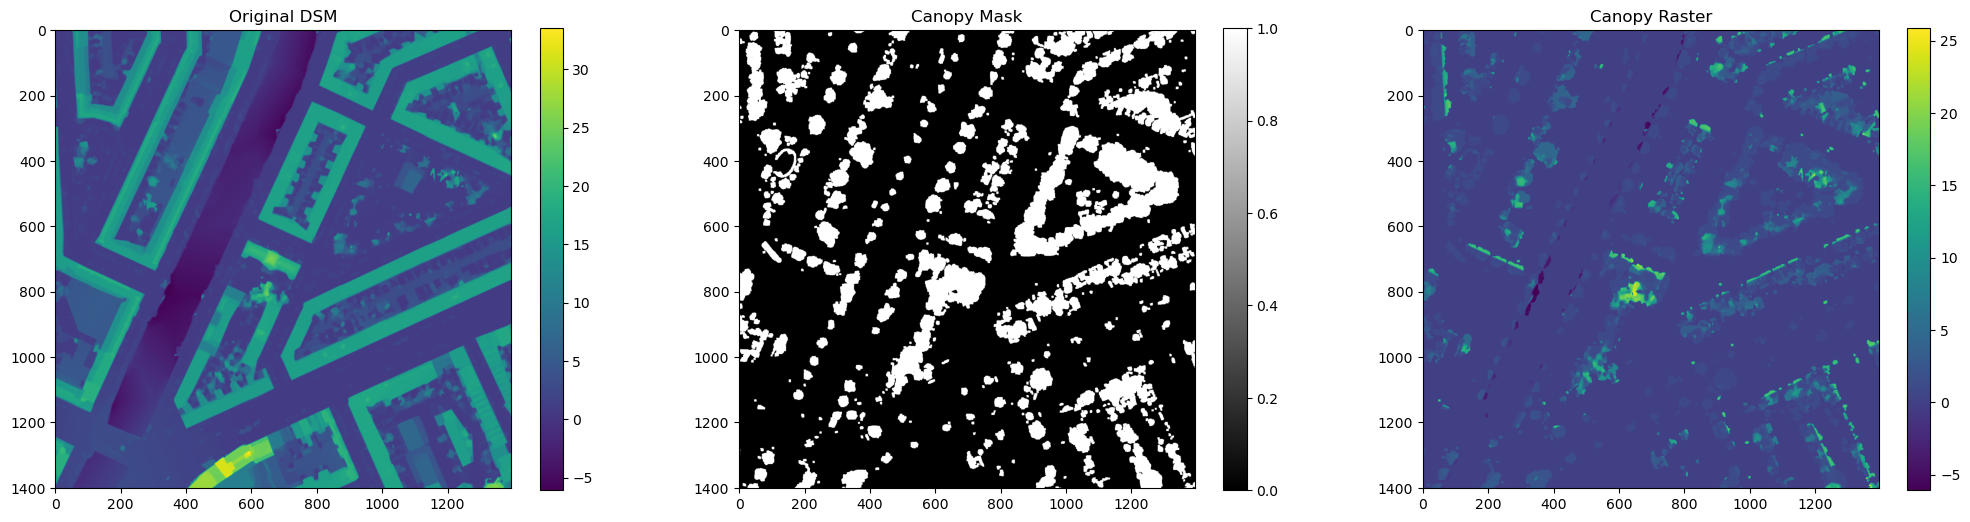

In [93]:
# Plot the original and filtered data for comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 6))

# Original data
cax1 = ax1.imshow(dsm_data, cmap='viridis')
ax1.set_title('Original DSM')
fig.colorbar(cax1, ax=ax1, orientation='vertical')


cax2 = ax2.imshow(combined_chm_mask, cmap='gray')
ax2.set_title('Canopy Mask')
fig.colorbar(cax2, ax=ax2, orientation='vertical')

# Filtered data
cax3 = ax3.imshow(canopy_dsm, cmap='viridis')
ax3.set_title('Canopy Raster')
fig.colorbar(cax3, ax=ax3, orientation='vertical')

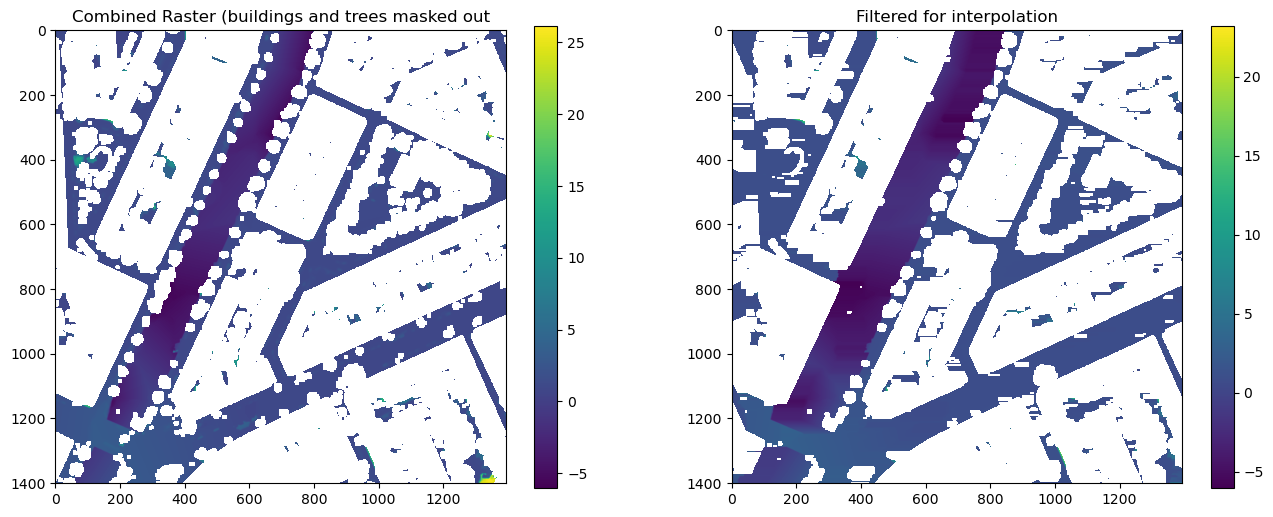

In [92]:
# Plot the original and filtered data for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Original data
cax1 = ax1.imshow(dtm_raw, cmap='viridis')
ax1.set_title('Combined Raster (buildings and trees masked out')
fig.colorbar(cax1, ax=ax1, orientation='vertical')


cax2 = ax2.imshow(filtered_data, cmap='viridis')
ax2.set_title('Filtered for interpolation')
fig.colorbar(cax2, ax=ax2, orientation='vertical')

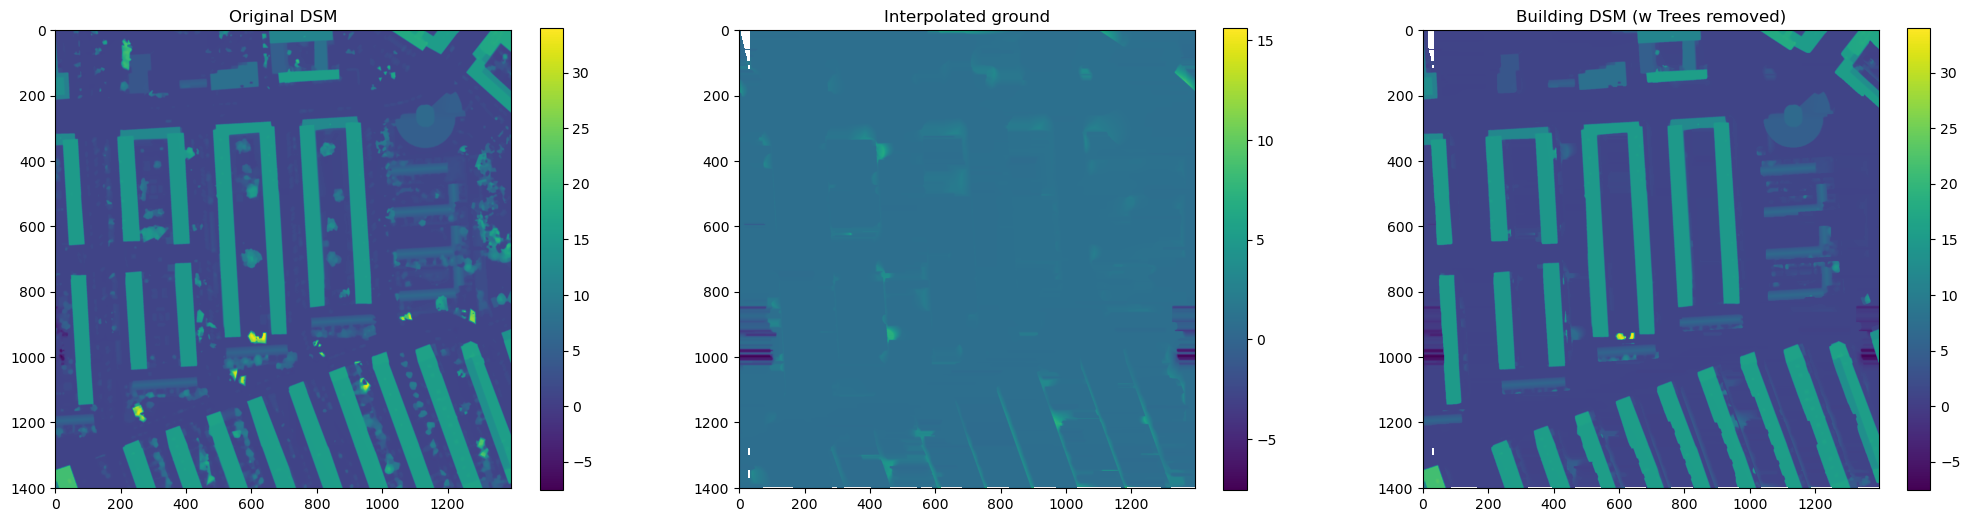

In [115]:
# Plot the original and filtered data for comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 6))

# Original data
cax1 = ax1.imshow(dsm_data, cmap='viridis')
ax1.set_title('Original DSM')
fig.colorbar(cax1, ax=ax1, orientation='vertical')


cax2 = ax2.imshow(post_interpol_filter, cmap='viridis')
ax2.set_title('Interpolated ground')
fig.colorbar(cax2, ax=ax2, orientation='vertical')

cax3 = ax3.imshow(dsm_buildings, cmap='viridis')
ax3.set_title('Building DSM (w Trees removed)')
fig.colorbar(cax3, ax=ax3, orientation='vertical')



Save raster data with pixels removed from edge:



### Up next:

- double-check that all have been downloaded
- run the processing script so that I have all of the input files
- run shade calculation for all, incrementally. Build function to run
    - building shade
    - building and tree shade

Shade functions:

- select date and other setup variables. 
- scan all files in folder (osmid, rdy for processing)
- run:
    - building shade only
    - building and tree shade

In [5]:
# Directory containing the raster files
processing_dir = f'../data/clean_data/solar/{osmid}/rdy_for_processing/'

# Get a list of all raster files in the directory so we can load them incrementally
building_files = glob.glob(os.path.join(processing_dir, '*building_dsm.tif'))

canopy_files = glob.glob(os.path.join(processing_dir, '*canopy_dsm.tif'))


print(len(building_files))

236


In [12]:
# Iterate over building_files and find matching paths in canopy_files
# TODO: Instead of append to list, why don't I just create a chm string within the for loop?
# DON'T FORGET TO CHANGE BACK TO USING COMPLETE LIST.
for bldg_path in building_files[0:2]:
    identifier = extract_identifier(bldg_path)
    matched_chm_path = []
    for chm_path in canopy_files:
        if identifier in chm_path:
            matched_chm_path.append(chm_path)

        # Check if the file exists
    if os.path.isfile(matched_chm_path[0]):
        print(f"The file {matched_chm_path[0]} exists.")
    else:
        print(f"The file {matched_chm_path[0]} does not exist.")
    # print(str(matched_chm_path[0]))
    
    # TODO: What is this? Not used, right?
    directory_list = ['building_shade','bldg_tree_shade']

    # subdirectory for each tile:
    folder_no = identifier.split('_')[-1]
    folder_no = '/' + folder_no
    tile_no = '/' + identifier
    
    building_directory = f'../results/output/{osmid}/building_shade{folder_no}/'

    tree_directory = f'../results/output/{osmid}/tree_shade{folder_no}/'

    building_shadow_files_exist = directory_check(building_directory)
    tree_shadow_files_exist = directory_check(tree_directory)

    if not building_shadow_files_exist:
    
        shade_bldg = shade.shadecalculation_setup(filepath_dsm = bldg_path, filepath_veg = str(matched_chm_path[0]), tile_no=tile_no, date = dt.datetime.now(), intervalTime = 30, onetime =0, filepath_save=building_directory, UTC=2, dst=1, useveg=0, trunkheight=25, transmissivity=20)

    if not tree_shadow_files_exist:
        shade_veg = shade.shadecalculation_setup(filepath_dsm = bldg_path, filepath_veg = matched_chm_path[0], tile_no=tile_no, date = dt.datetime.now(), intervalTime = 30, onetime =0, filepath_save=tree_directory, UTC=2, dst=1, useveg=1, trunkheight=25, transmissivity=20)


The file ../data/clean_data/solar/15419236/rdy_for_processing/15419236_p_76_2010_01_01_canopy_dsm.tif exists.
Directory ../results/output/15419236/building_shade/76/ created.
Directory ../results/output/15419236/building_shade/76/ already exists.
No files containing 'shadow_fraction_on_' found.
Directory ../results/output/15419236/tree_shade/76/ created.
Directory ../results/output/15419236/tree_shade/76/ already exists.
No files containing 'shadow_fraction_on_' found.
2024-07-17 15:30:35.230771
PROJCS["WGS 84 / UTM zone 31N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1

## Stepwise archive file:



In [ ]:
### WORKING UNTIL HERE:

# Process each DSM file
for path in raster_files[120:]:
    # Read DSM
    with rasterio.open(path) as src:
        dsm_data = src.read(1)
        dsm_meta = src.meta.copy()
        dsm_crs = src.crs
        dsm_bounds = src.bounds
        dsm_transform = src.transform
        dsm_shape = dsm_data.shape

    # Create a bounding box polygon from the raster bounds
    dsm_bbox = box(dsm_bounds.left, dsm_bounds.bottom, dsm_bounds.right, dsm_bounds.top)
    # Convert the bounding box to a GeoDataFrame and assign the raster's CRS
    dsm_bbox_gdf = gpd.GeoDataFrame({'geometry': [dsm_bbox]}, crs=dsm_crs)

    # Load corresponding AHN subtiles
    subtiles_path = '../data/raw_data/ahn/AHN_subunits_GeoTiles.shp'
    subtiles = gpd.read_file(subtiles_path, mask=dsm_bbox_gdf)
    if subtiles.crs != dsm_crs:
        subtiles = subtiles.to_crs(dsm_crs)
    
    tile_list = list(subtiles.GT_AHNSUB)
    chm_path = '/Users/lbeuster/Documents/TU Delft/Projects/lidR/data/gilfoyle/results/'

    chm_tile_paths = []

    for tile in tile_list:
        full_path = chm_path + tile + '.tif'
        chm_tile_paths.append(full_path)
        print(chm_tile_paths)

    # Initialize a mask with the same shape as the DSM data
    combined_mask = np.zeros(dsm_shape, dtype=bool)

    # Loop through the additional raster files and update the combined mask
    for raster_path in chm_tile_paths:
        update_mask_within_extent(raster_path, combined_mask, dsm_bounds, dsm_transform, dsm_crs, dsm_shape)

    # The combined_mask can now be applied to the dsm_data as required
    canopy_dsm = np.where(combined_mask, dsm_data, np.nan)  # Use NaN for masked-out areas

    break  # For testing, only process the first DSM file

['/Users/lbeuster/Documents/TU Delft/Projects/lidR/data/gilfoyle/results/25BZ2_24.tif']


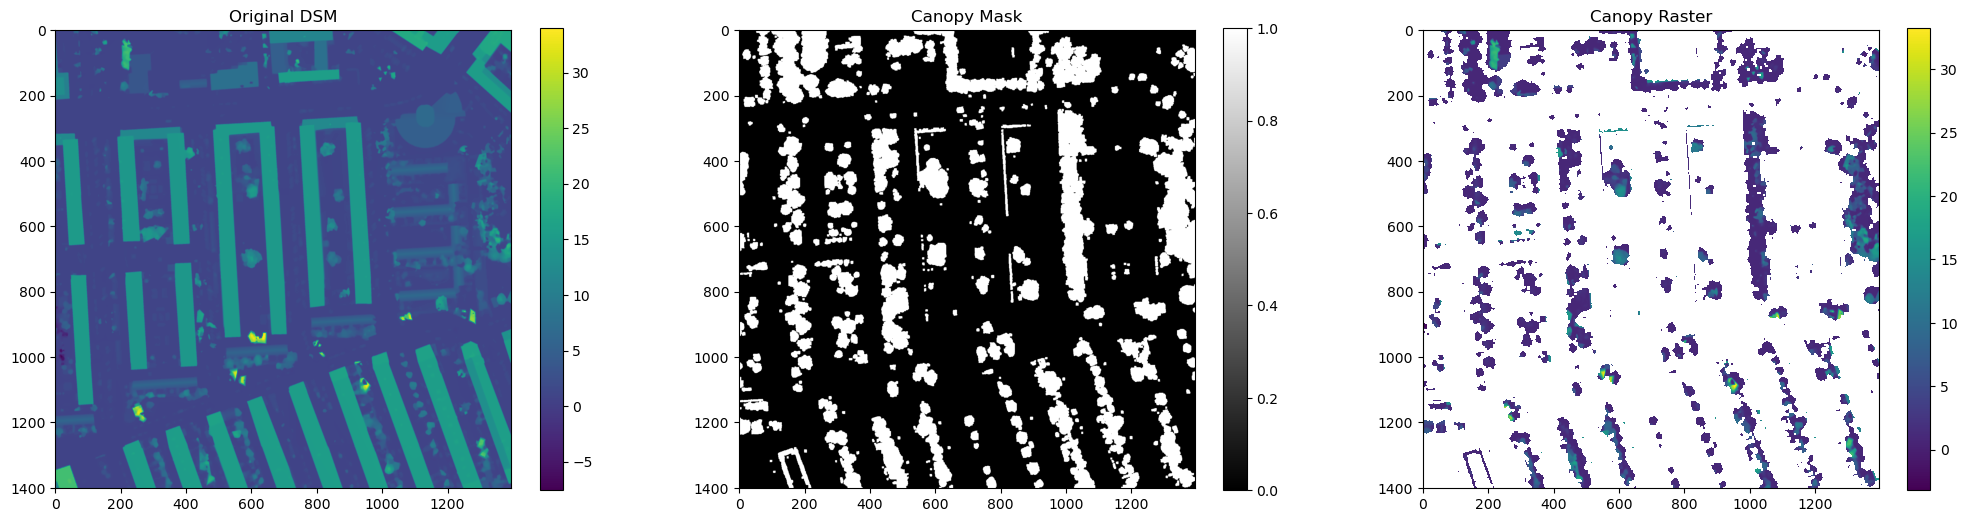

In [ ]:
# Plot the original and filtered data for comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 6))

# Original data
cax1 = ax1.imshow(dsm_data, cmap='viridis')
ax1.set_title('Original DSM')
fig.colorbar(cax1, ax=ax1, orientation='vertical')


cax2 = ax2.imshow(combined_mask, cmap='gray')
ax2.set_title('Canopy Mask')
fig.colorbar(cax2, ax=ax2, orientation='vertical')

# Filtered data
cax3 = ax3.imshow(canopy_dsm, cmap='viridis')
ax3.set_title('Canopy Raster')
fig.colorbar(cax3, ax=ax3, orientation='vertical')

In [ ]:
m = dsm_bbox_gdf.explore()

subtiles.explore(m=m)
m

In [ ]:
### WORKING UNTIL CREATION OF MASKED OUT DSM BEFORE INTERPOLATION
# Process each DSM file
for path in raster_files[150:]:
    # Read DSM
    with rasterio.open(path) as src:
        dsm_data = src.read(1)
        dsm_meta = src.meta.copy()
        dsm_crs = src.crs
        dsm_bounds = src.bounds
        dsm_transform = src.transform
        dsm_shape = dsm_data.shape


    # Create a bounding box polygon from the raster bounds
    dsm_bbox = box(dsm_bounds.left, dsm_bounds.bottom, dsm_bounds.right, dsm_bounds.top)
    # Convert the bounding box to a GeoDataFrame and assign the raster's CRS
    dsm_bbox_gdf = gpd.GeoDataFrame({'geometry': [dsm_bbox]}, crs=dsm_crs)

    # Load corresponding AHN subtiles
    subtiles_path = '../data/raw_data/ahn/AHN_subunits_GeoTiles.shp'
    subtiles = gpd.read_file(subtiles_path, mask=dsm_bbox_gdf)
    if subtiles.crs != dsm_crs:
        subtiles = subtiles.to_crs(dsm_crs)
    
    tile_list = list(subtiles.GT_AHNSUB)
    chm_path = '/Users/lbeuster/Documents/TU Delft/Projects/lidR/data/gilfoyle/results/'

    chm_tile_paths = []

    for tile in tile_list:
        full_path = chm_path + tile + '.tif'
        chm_tile_paths.append(full_path)
        print(chm_tile_paths)

    # Initialize a mask with the same shape as the DSM data
    combined_chm_mask = np.zeros(dsm_shape, dtype=bool)

    # Loop through the additional raster files and update the combined mask
    for raster_path in chm_tile_paths:
        update_mask_within_extent(raster_path, combined_chm_mask, dsm_bounds, dsm_transform, dsm_crs, dsm_shape)

    # The combined_mask can now be applied to the dsm_data as required
    canopy_dsm = np.where(combined_chm_mask, dsm_data, np.nan)  # Use NaN for masked-out areas

    # Read building_mask
    mask_path = path.replace("dsm", "mask")

    with rasterio.open(mask_path) as src:
        bldg_mask = src.read(1)
        bldg_mask_meta = src.meta.copy()
        bldg_transform = src.transform
        bldg_crs = src.crs
        bldg_dtype = src.dtypes[0]

    # Read osm_buildings

    # Load corresponding AHN subtiles
    buildings_path = f'../data/clean_data/solar/{osmid}/{osmid}_buildings.gpkg'
    buildings = gpd.read_file(buildings_path, mask=dsm_bbox_gdf)
    if buildings.crs != dsm_crs:
        buildings = buildings.to_crs(dsm_crs)

    # Buffer to combat artefacts.
    buildings.geometry = buildings.buffer(1.5)

    # Rasterize building polygons (same size as dsm so it works with UMEP)
    osm_bldg_mask = rasterize(
        ((mapping(geom), 1) for geom in buildings.geometry),
        out_shape=dsm_data.shape,
        transform=dsm_meta['transform'],
        fill=0,
        dtype='uint8'
    )

    combined_building_mask = np.logical_or(bldg_mask, osm_bldg_mask).astype(np.uint8)
    combined_bldg_tree_mask = np.logical_or(combined_chm_mask, combined_building_mask).astype(np.uint8)

    dtm_raw = np.where(combined_bldg_tree_mask == 0, dsm_data, np.nan)

    ### Filter the raw data
    ## Apply minimum filter
    filtered_data = apply_minimum_filter(dtm_raw, np.nan, size=50)
    # filtered_data = apply_minimum_filter(filtered_data, np.nan, size=50)
    filtered_data = apply_minimum_filter(filtered_data, np.nan, size=30)
    filtered_data = apply_minimum_filter(filtered_data, np.nan, size=10)



    break  # For testing, only process the first DSM file



# # Save the filtered DSM data to a new raster file (optional step)
# filtered_dsm_path = 'path/to/your/filtered_dsm.tif'
# dsm_meta.update(dtype=rasterio.float32, nodata=np.nan)

# with rasterio.open(filtered_dsm_path, 'w', **dsm_meta) as dst:
#     dst.write(filtered_dsm_data.astype(rasterio.float32), 1)

['/Users/lbeuster/Documents/TU Delft/Projects/lidR/data/gilfoyle/results/25EZ1_16.tif']
['/Users/lbeuster/Documents/TU Delft/Projects/lidR/data/gilfoyle/results/25EZ1_16.tif', '/Users/lbeuster/Documents/TU Delft/Projects/lidR/data/gilfoyle/results/25BZ2_20.tif']
Filtering: Ignoring Nodata
Filtering: Ignoring Nodata
Filtering: Ignoring Nodata


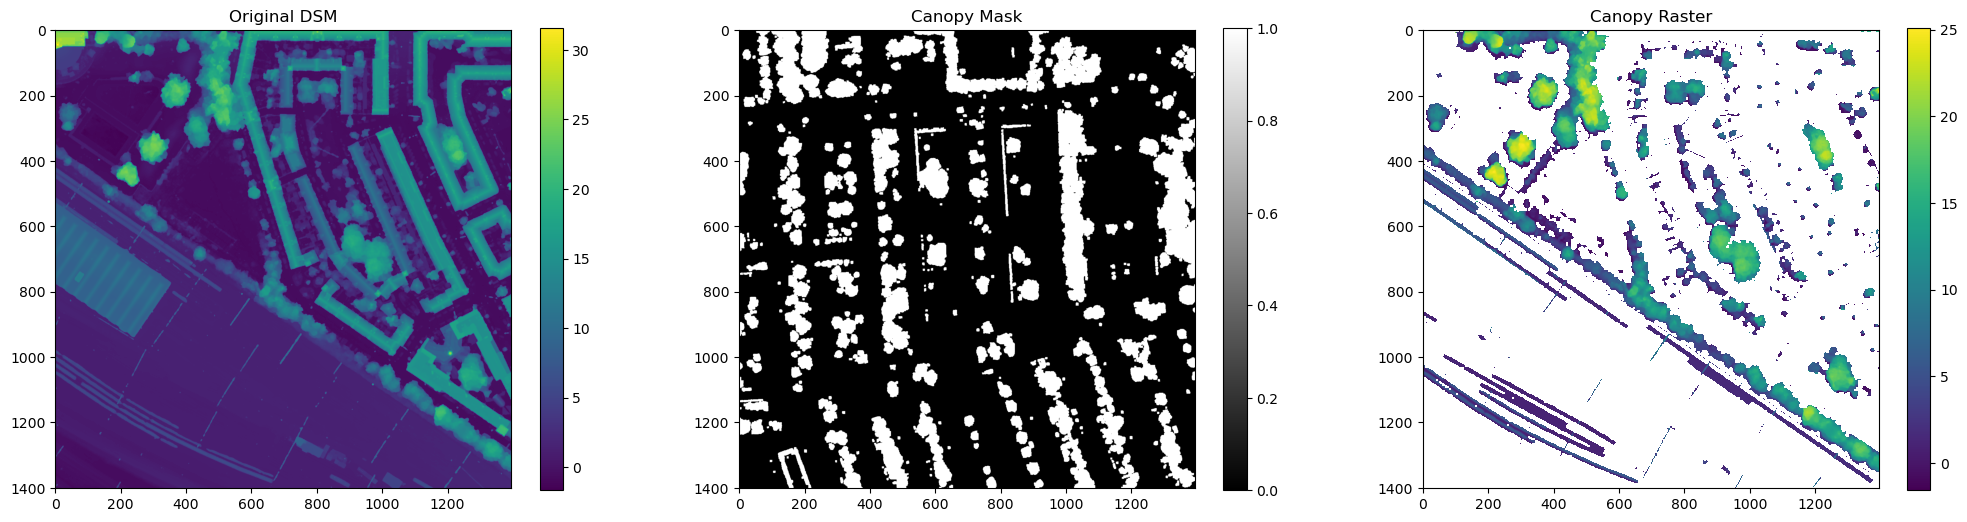

In [ ]:
# Plot the original and filtered data for comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 6))

# Original data
cax1 = ax1.imshow(dsm_data, cmap='viridis')
ax1.set_title('Original DSM')
fig.colorbar(cax1, ax=ax1, orientation='vertical')


cax2 = ax2.imshow(combined_mask, cmap='gray')
ax2.set_title('Canopy Mask')
fig.colorbar(cax2, ax=ax2, orientation='vertical')

# Filtered data
cax3 = ax3.imshow(canopy_dsm, cmap='viridis')
ax3.set_title('Canopy Raster')
fig.colorbar(cax3, ax=ax3, orientation='vertical')

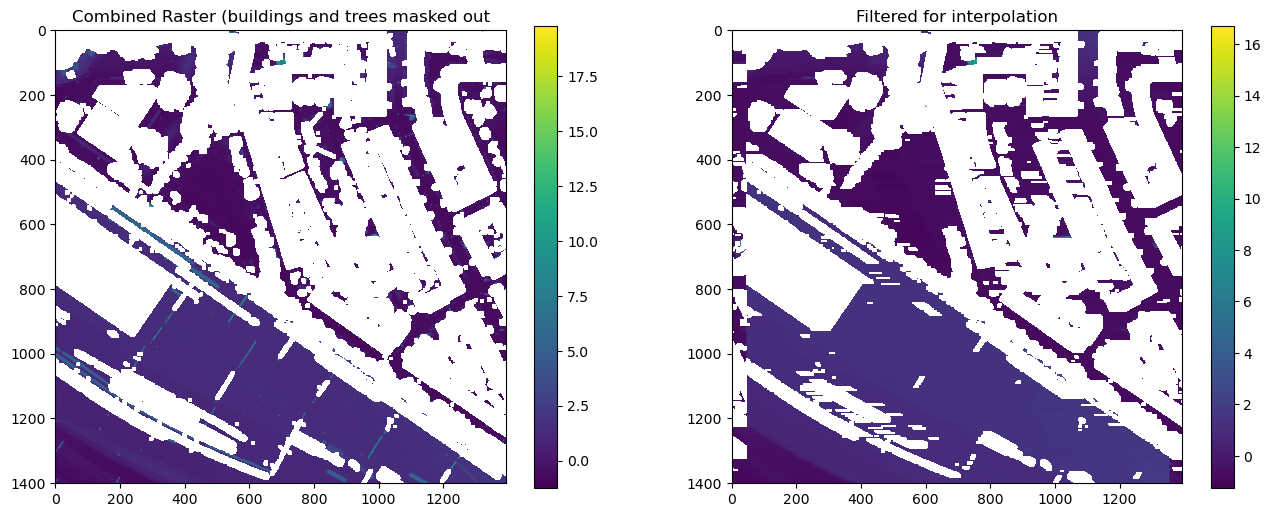

In [ ]:
# Plot the original and filtered data for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Original data
cax1 = ax1.imshow(dtm_raw, cmap='viridis')
ax1.set_title('Combined Raster (buildings and trees masked out')
fig.colorbar(cax1, ax=ax1, orientation='vertical')


cax2 = ax2.imshow(filtered_data, cmap='viridis')
ax2.set_title('Filtered for interpolation')
fig.colorbar(cax2, ax=ax2, orientation='vertical')